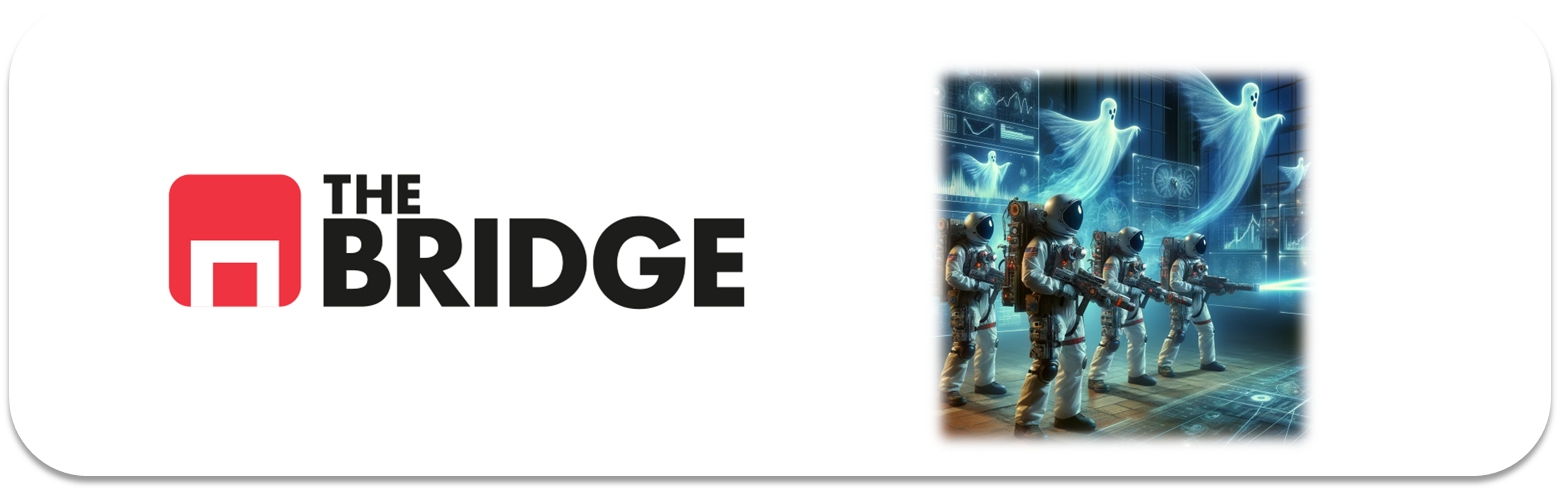

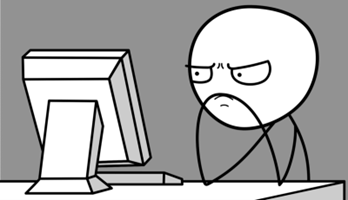

Para ejercitarte y afianzar lo aprendido sobre **Series Temporales**, completa los siguientes ejercicios. Recuerda que necesitarás datos que están en el directorio data que acompaña al notebook (búscalo en el repositorio de ejercicios)
  
La solución a los mismos las tienes ya, intenta no mirarlos de primeras pero no dejes de hacerlo cuando hayas terminado por si te pudieran aportar.

### El "problema"

Para este ejercicio vamos a predecir cuál será la demanda de pasajeros de una aerolinea, para poder anticiparse a las contrataciones de personal, mantenimiento de las aeronaves y gestión de inventario y comidas.

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")


### Ejercicio 1

Carga los datos y adecúa el dataset teniendo en cuenta que es una serie temporal. Para ello convierte la columna de fecha al formato adecuado y luego úsala como índice.

In [3]:
df = pd.read_csv("./data/AirPassengers.csv")

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    144 non-null    object
 1   value   144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [6]:
df.head()

,date,value
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


In [8]:
#fecha en formato datetime
df["Date"] = pd.to_datetime(df["date"])

#usamos fecha como indice
df.set_index("Date", inplace=True)

### Ejercicio 2

¿De qué fecha a qué fecha va el histórico?¿Qué periodicidad tiene la serie?

In [9]:
#determinamos el período histórico
print("Fecha de inicio:", df.index.min())
print("Fecha de fin:", df.index.max())
print("Frecuencia de la serie:", df.index.freq)

Fecha de inicio: 1949-01-01 00:00:00
Fecha de fin: 1960-12-01 00:00:00
Frecuencia de la serie: None


### Ejercicio 3

¿Cómo es la serie temporal? ¿Tiene tendencia? ¿Aprecias alguna estacionalidad? Analiza de manera gráfica, pero todavía sin descomponer la serie.

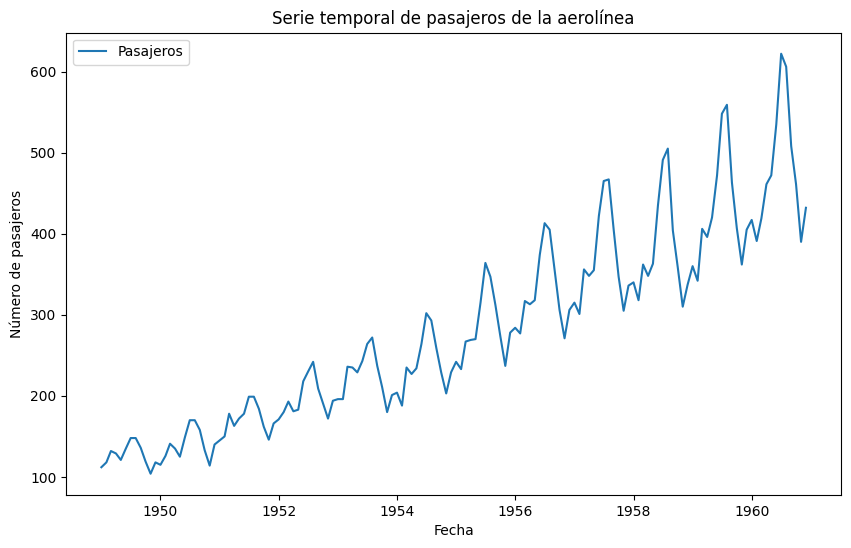

In [11]:
#grafico de la serie completa
plt.figure(figsize=(10, 6))
plt.plot(df.index, df["value"], label="Pasajeros")
plt.xlabel("Fecha")
plt.ylabel("Número de pasajeros")
plt.title("Serie temporal de pasajeros de la aerolínea")
plt.legend()
plt.show()

### Ejercicio 4

¿Podrías demostrar de dos maneras estadísticas que la serie no es estacionaria?

In [13]:
#prueba de Dickey-Fuller aumentada (ADF)
result = adfuller(df["value"])
print("Estadístico ADF:", result[0])
print("Valor p:", result[1])
print("Valores críticos:", result[4])

Estadístico ADF: 0.8153688792060482
Valor p: 0.991880243437641
Valores críticos: {'1%': -3.4816817173418295, '5%': -2.8840418343195267, '10%': -2.578770059171598}


La prueba de Dickey-Fuller da como resultado muy cercano a 1, lo que demuestra que la serie no es estacionaria.
El p-value es mayor de 0.05, también lo demuestra.
El resultado de la prueba de Dickey-Fuller es positivo y mayor que los valores críticos, lo que también demuestra que la serie no es estacionaria.

### Ejercicio 5

Emplea la descomposición que hemos aprendido en el workout para representar gráficamente la tendencia. Si has mostrado gráficamente la tendencia en el ejercicio 3, compara ambos.

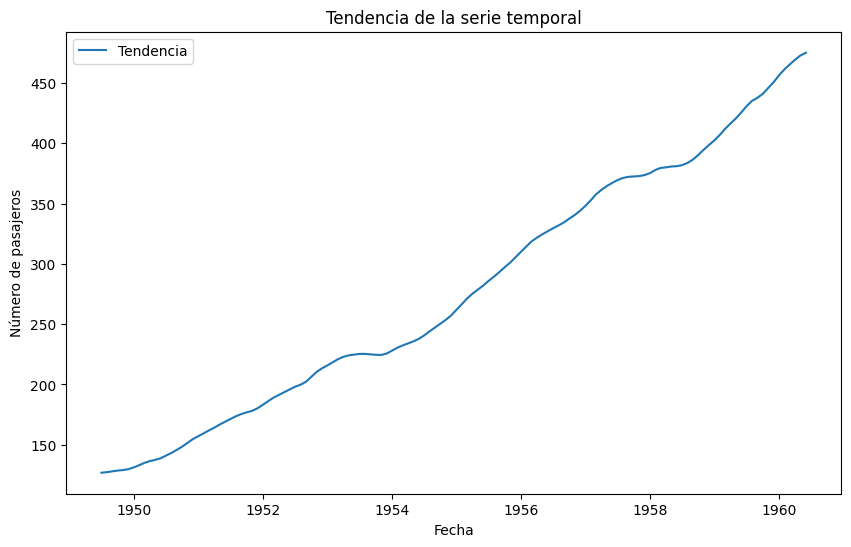

In [15]:
decomposition = seasonal_decompose(df["value"], model="additive")
trend = decomposition.trend

#grafico de la tendencia
plt.figure(figsize=(10, 6))
plt.plot(df.index, trend, label="Tendencia")
plt.xlabel("Fecha")
plt.ylabel("Número de pasajeros")
plt.title("Tendencia de la serie temporal")
plt.legend()
plt.show()

Comprobamos que la tendencia en ambos gráficos (ejercicios 3 y 5) es la misma.

### Ejercicio 6

Visualiza todos los componentes de la serie temporal por separado

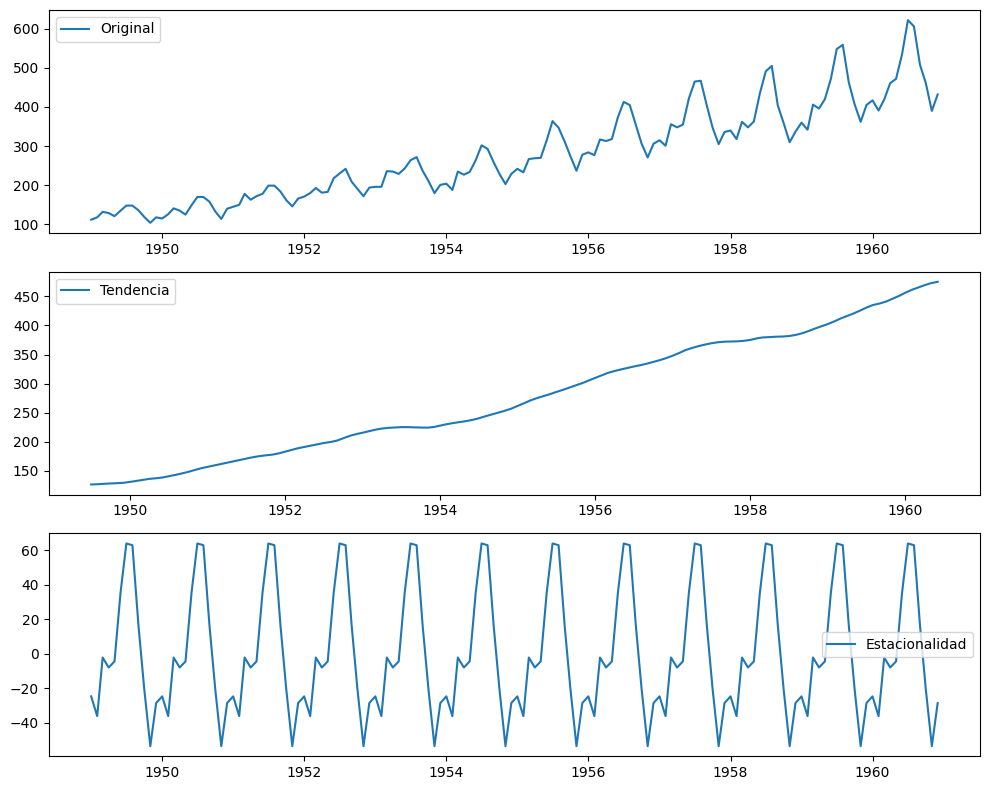

In [17]:
#grafico de componentes
plt.figure(figsize=(10, 8))
plt.subplot(3, 1, 1)
plt.plot(df.index, df["value"], label="Original")
plt.legend()
plt.subplot(3, 1, 2)
plt.plot(df.index, trend, label="Tendencia")
plt.legend()
plt.subplot(3, 1, 3)
plt.plot(df.index, decomposition.seasonal, label="Estacionalidad")
plt.legend()
plt.tight_layout()
plt.show()

### Ejercicio 7

Crea una matriz de correlación con los últimos 24 instantes (matriz de autocorrelación). Crea un dataframe con shift de 1 a 24 para ello, la idea es que puedas hacer una matriz de correlación con el valor actual y los 24 valores anteriores. Es decir de un mes con sus 23 meses anteriores. Interpreta la estacionalidad

In [19]:
#creamos el dataframe con shifts
shifted_data = df["value"].shift(periods=24)

#calculamos la matriz de correlación
correlation_matrix = pd.concat([df["value"], shifted_data], axis=1).corr()
print(correlation_matrix)


          value     value
value  1.000000  0.983254
value  0.983254  1.000000


Hay una alta correlación entre el valor actual y los valores anteriores, lo que significa que hay estacionalidad en la serie temporal.

### Ejercicio 8
Ya hemos visto que hay seasonality. ¿Cada cuántos instantes se cumple ese patrón?

La estacionalidad se repite cada año.


### Ejercicio 9

 Divide en train y test. En este caso no haremos división en validación, entre otras razones por la cantidad de datos que tenemos. Guarda 20 muestras para test.

In [22]:
train_size = len(df) - 20
train, test = df.iloc[:train_size], df.iloc[train_size:]


### Ejercicio 10

Pon en práctica lo visto en clases, crea un modelo de ARIMA (puedes utilizar autoarima), mide su RMSE y su MAPE. Comparalo gráficamente con los valores reales.

In [32]:
#creamos el modelo ARIMA
model_arima = ARIMA(train["value"], order=(5, 1, 1))
model_arima_fit = model_arima.fit()

#hacemos las predicciones
predictions_arima = model_arima_fit.forecast(steps=len(test))[0]

#calculamos los errores
rmse_arima = mean_squared_error(test["value"], predictions_arima, squared=False)
mape_arima = mean_absolute_percentage_error(test["value"], predictions_arima)

print("RMSE (ARIMA):", rmse_arima)
print("MAPE (ARIMA):", mape_arima)

InvalidParameterError: The 'y_pred' parameter of mean_squared_error must be an array-like. Got 390.22957703745874 instead.

### Ejercicio 11

Haz lo mismo que en el ejercicio 10 pero con un modelo SARIMA. ¿Cuál es mejor y por qué?

In [28]:
#creamos el modelo SARIMA
model_sarima = SARIMAX(train["value"], order=(5, 1, 1), seasonal_order=(1, 1, 1, 12))
model_sarima_fit = model_sarima.fit()

#hacemos las predicciones
predictions_sarima = model_sarima_fit.get_forecast(steps=len(test))
predicted_mean_sarima = predictions_sarima.predicted_mean

#calculamos los errores
rmse_sarima = mean_squared_error(test["value"], predicted_mean_sarima, squared=False)
mape_sarima = mean_absolute_percentage_error(test["value"], predicted_mean_sarima)

print("RMSE (SARIMA):", rmse_sarima)
print("MAPE (SARIMA):", mape_sarima)

RMSE (SARIMA): 32.12551804741436
MAPE (SARIMA): 0.05985961538225123


Tanto el RMSE como el MAPE son bajos, lo que indica que las precisiones son precisas